## Fetch windows, zscores, annotations

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import pandas as pd 
import numpy as np 

pd.set_option('display.max_columns', 50)
pd.set_option('max_colwidth', 50)
pd.set_option('display.max_rows', 100)

TRAIN_SET_LABEL = 'noncoding'
KMER_SIZE = 3 
SAMPLE_SIZE = 100000

In [2]:
def compute_N_mean_null_chen(row): 
    a = 1 
    b = -(2*row['N_observed'] + row['new chen zscore']**2)
    c = row['N_observed']**2
    sqrt = np.sqrt(b**2 - 4*a*c)
    sign = 1 if row['new chen zscore'] > 0 else -1
    return (-b + sign*sqrt)/(2*a)
    
def get_windows_scores_annotations_noncoding():
    filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon.positive-vista-enhancers.bed'
    df = pd.read_csv(filename, sep='\t')
    df['window overlaps positive vista enhancer'] = df['positive-vista-enhancer count'] > 0    
    df['negative new chen zscore'] = -df['new chen zscore']
    df['N_mean_null_chen'] = df.apply(compute_N_mean_null_chen, axis=1)
    df = df[df['window overlaps merged_exon'] == False]
    return df

windows_scores_annotations_noncoding = get_windows_scores_annotations_noncoding()
windows_scores_annotations_noncoding

,chromosome,start,end,N_observed,N_bar_7_noncoding,N_mean_null_7_noncoding,N_variance_null_7_noncoding,N_bar_1_noncoding,N_mean_null_1_noncoding,N_variance_null_1_noncoding,N_bar_1_noncoding_noisy,N_mean_null_1_noncoding_noisy,N_variance_null_1_noncoding_noisy,N_bar_3_noncoding,N_mean_null_3_noncoding,N_variance_null_3_noncoding,N_bar_3_noncoding_noisy,N_mean_null_3_noncoding_noisy,N_variance_null_3_noncoding_noisy,N_bar_5_noncoding,N_mean_null_5_noncoding,N_variance_null_5_noncoding,N_bar_5_noncoding_noisy,N_mean_null_5_noncoding_noisy,N_variance_null_5_noncoding_noisy,enhancer overlap,merged_exon overlap,window overlaps enhancer,window overlaps merged_exon,"window overlaps (enhancer, merged_exon)",new chen zscore,positive-vista-enhancer count,window overlaps positive vista enhancer,negative new chen zscore,N_mean_null_chen
0,chr1,1432000,1433000,260,-0.372778,265.321432,203.777753,1.590921,236.519249,217.834403,1.676924,235.282294,217.264932,-0.247615,263.528599,203.072610,-0.283079,264.038617,203.540686,-0.339806,264.852332,203.910737,-0.340167,264.858613,204.004160,1000.0,NaN,True,False,"(True, False)",4.299894,0,False,-4.299894,339.191842
4,chr1,1451000,1452000,293,2.951595,252.829443,185.226049,4.803930,223.924244,206.755939,4.877094,222.953222,206.278524,2.367303,260.131776,192.772432,2.332657,260.580640,193.155585,2.725116,255.650992,187.839972,2.724052,255.656435,187.931976,NaN,NaN,False,False,"(False, False)",0.666316,0,False,-0.666316,304.629643
5,chr1,1453000,1454000,260,1.389878,241.020405,186.474887,2.689522,221.525196,204.645755,2.756958,220.604827,204.185875,1.023579,245.832671,191.572571,0.992448,246.250157,191.946387,1.164984,243.990074,188.859460,1.165733,243.977693,188.908549,NaN,NaN,False,False,"(False, False)",0.828398,0,False,-0.828398,273.705039
7,chr1,1458000,1459000,274,2.218475,243.876098,184.379757,3.705533,221.045386,204.223718,3.773446,220.135148,203.767346,1.921190,247.467287,190.731630,1.888404,247.889450,191.179831,2.115020,244.993521,188.087927,2.116651,244.964374,188.175894,NaN,NaN,False,False,"(False, False)",-0.086128,0,False,0.086128,272.578031
11,chr1,1463000,1464000,192,-1.944466,218.459904,185.172213,-2.095294,222.005005,205.067792,-2.032614,221.074506,204.604405,-2.085869,220.639685,188.522242,-2.105358,220.933952,188.870201,-2.012778,219.516464,186.893272,-2.012358,219.510874,186.895193,28.0,NaN,True,False,"(True, False)",2.948188,0,False,-2.948188,237.427713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786070,chr9,137262000,137263000,303,4.459653,242.258268,185.512060,6.063733,217.086956,200.741915,6.128607,216.260297,200.314475,4.256927,244.570154,188.398345,4.225083,244.951922,188.757918,4.403686,242.982775,185.745859,4.407979,242.924712,185.743064,346.0,NaN,True,False,"(True, False)",-2.396149,0,False,2.396149,264.062571
1786071,chr9,137268000,137269000,215,-1.116078,230.165809,184.647017,-0.579673,223.324482,206.228393,-0.513527,222.366123,205.755362,-1.149755,230.788702,188.574204,-1.181149,231.237963,188.996595,-1.180274,231.159081,187.442292,-1.182392,231.190082,187.488718,1000.0,NaN,True,False,"(True, False)",3.640544,0,False,-3.640544,275.417393
1786072,chr9,137269000,137270000,210,-3.060479,251.650751,185.210985,-0.657779,219.366052,202.746590,-0.596997,218.491272,202.302491,-3.445370,257.657992,191.337298,-3.474260,258.105694,191.720447,-3.228932,254.283943,188.093965,-3.225423,254.247196,188.190706,1000.0,NaN,True,False,"(True, False)",5.276351,0,False,-5.276351,301.638272
1786073,chr9,137275000,137276000,296,1.990841,268.077912,196.708291,4.575436,229.442056,211.609361,4.655896,228.354529,211.091617,1.921453,268.932391,198.445131,1.881115,269.472162,198.871703,1.974808,268.272874,197.133316,1.977276,268.231681,197.226096,712.0,NaN,True,False,"(True, False)",2.687348,0,False,-2.687348,345.986596


## p-values are well-calibrated when SNV counts are sampled from null

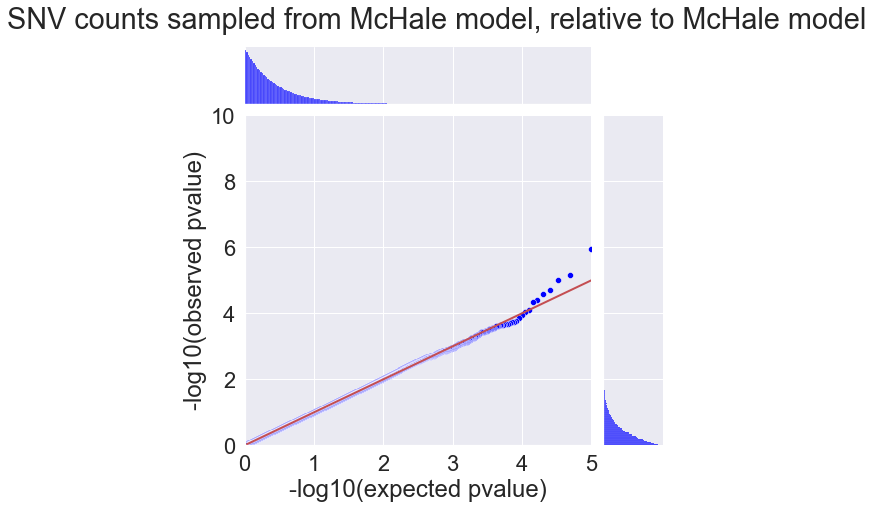

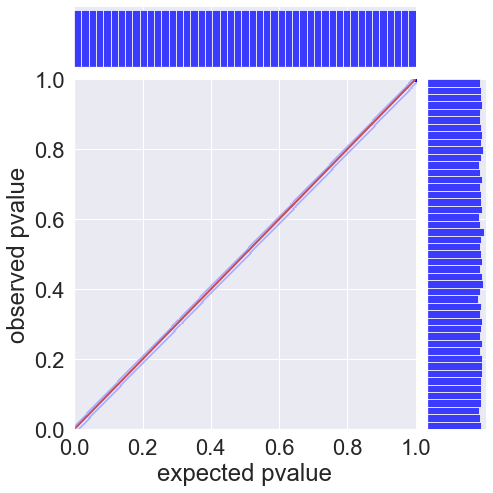

In [7]:
from scipy.stats import norm

import matplotlib.pyplot as plt 
plt.rcParams.update({
#     'font.size': 20,
    'figure.figsize': (12, 6)
})

import seaborn as sns 
sns.set(font_scale=2)

def compute_pvalue_null(df): 
    theta_mean, theta_variance = (
        df[f'N_mean_null_{KMER_SIZE}_{TRAIN_SET_LABEL}'], 
        df[f'N_variance_null_{KMER_SIZE}_{TRAIN_SET_LABEL}']
    )
    N_observed = np.random.normal(theta_mean, np.sqrt(theta_variance))
    p_value = norm.cdf(N_observed, loc=theta_mean, scale=np.sqrt(theta_variance))
    return p_value, 'SNV counts sampled from McHale model, relative to McHale model'

def generate_qq_plot_for_pvalues(df, compute_pvalue):
    p_values, name = compute_pvalue(df)
    
    # https://github.com/petermchale/QQ-plots/blob/master/qq-plots.pdf
    observed_order_statistics = np.sort(p_values)
    expected_order_statistics = [(i+1)/(len(df)+1) for i in range(len(df))]    

    g = sns.jointplot(
        x=-np.log10(expected_order_statistics), 
        y=-np.log10(observed_order_statistics), 
        kind='scatter', 
        xlim=[0, 5], 
        ylim=[0, 10],
        color="blue", 
        height=7
    )
    g.ax_joint.plot([0, 5], [0, 5], 'r-', linewidth=2)
    g.ax_joint.set_xlabel('-log10(expected pvalue)')
    g.ax_joint.set_ylabel('-log10(observed pvalue)')
    g.fig.suptitle(name)
    g.fig.subplots_adjust(top=0.9) 
    plt.show()

    g = sns.jointplot(
        x=expected_order_statistics, 
        y=observed_order_statistics, 
        kind='scatter', 
        xlim=(0, 1), 
        ylim=(0, 1),
        color="blue", 
        height=7
    )
    g.ax_joint.plot([0, 1], [0, 1], 'r-', linewidth=2)
    g.ax_joint.set_xlabel('expected pvalue')
    g.ax_joint.set_ylabel('observed pvalue')

generate_qq_plot_for_pvalues(windows_scores_annotations_noncoding.sample(n=SAMPLE_SIZE), compute_pvalue_null)

## Observed p-values are poorly calibrated in practice

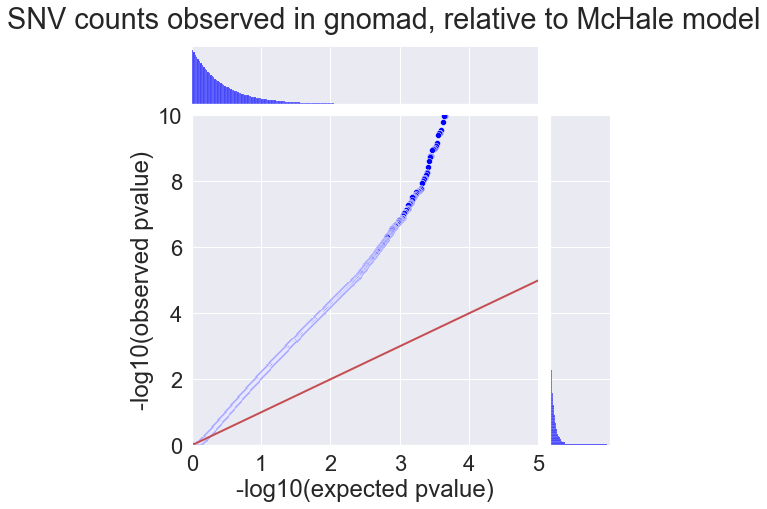

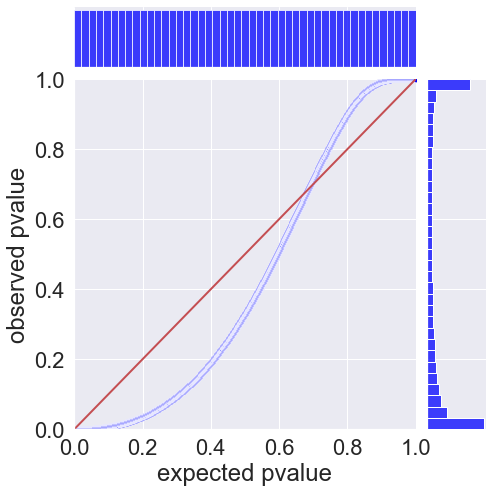

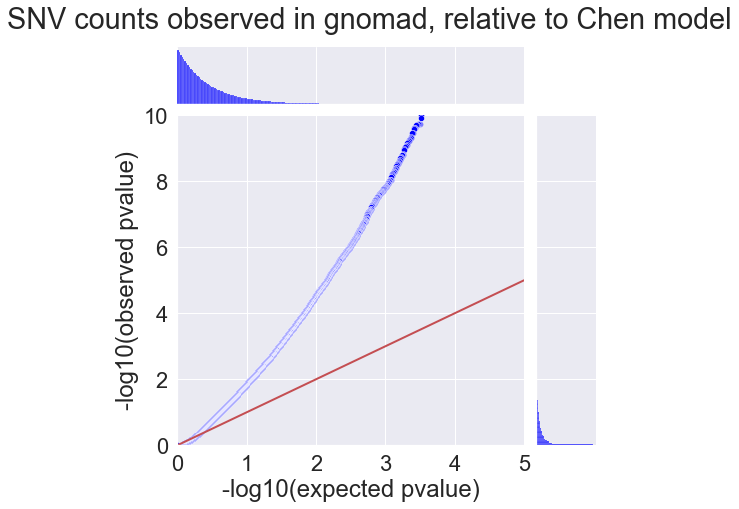

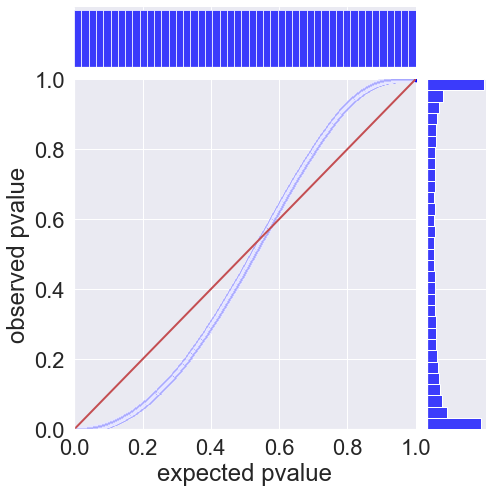

In [8]:
def compute_pvalue_mchale(df): 
    N_observed, theta_mean, theta_variance = (
        df['N_observed'],
        df[f'N_mean_null_{KMER_SIZE}_{TRAIN_SET_LABEL}'], 
        df[f'N_variance_null_{KMER_SIZE}_{TRAIN_SET_LABEL}']
    )
    p_value = norm.cdf(N_observed, loc=theta_mean, scale=np.sqrt(theta_variance))
    return p_value, 'SNV counts observed in gnomad, relative to McHale model' 

def compute_pvalue_chen(df): 
    N_observed, theta_mean = (
        df['N_observed'],
        df['N_mean_null_chen'], 
    )
    theta_variance = theta_mean # assume Poisson 
    p_value = norm.cdf(N_observed, loc=theta_mean, scale=np.sqrt(theta_variance))
    return p_value, 'SNV counts observed in gnomad, relative to Chen model' 

generate_qq_plot_for_pvalues(windows_scores_annotations_noncoding.sample(n=SAMPLE_SIZE), compute_pvalue_mchale)
generate_qq_plot_for_pvalues(windows_scores_annotations_noncoding.sample(n=SAMPLE_SIZE), compute_pvalue_chen)

## z-scores are well calibrated when SNV counts are sampled from null

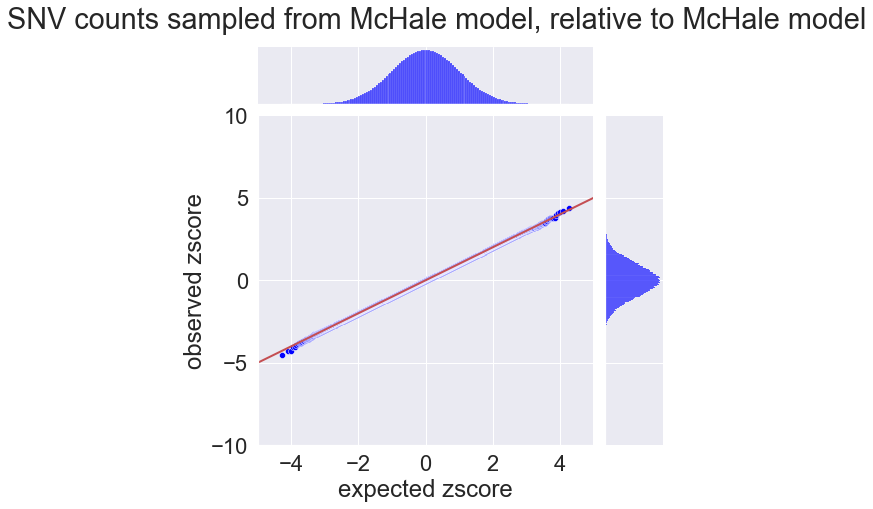

In [5]:
def compute_null_zscores(df): 
    theta_mean, theta_variance = (
        df[f'N_mean_null_{KMER_SIZE}_{TRAIN_SET_LABEL}'], 
        df[f'N_variance_null_{KMER_SIZE}_{TRAIN_SET_LABEL}']
    )
    N_observed = np.random.normal(theta_mean, np.sqrt(theta_variance))
    zscores = (N_observed - theta_mean)/np.sqrt(theta_variance)
    return zscores, 'SNV counts sampled from McHale model, relative to McHale model' 

def generate_qq_plot_for_zscores(df, compute_zscores):   
    zscores, name = compute_zscores(df)
    # https://nbviewer.org/github/petermchale/QQ-plots/blob/master/analysis.ipynb
    observed_order_statistics = np.sort(zscores)
    cdf_values = [(i+1)/(len(df)+1) for i in range(len(df))]
    expected_order_statistics = norm.ppf(cdf_values) # invert cdf
    g = sns.jointplot(
        x=expected_order_statistics, 
        y=observed_order_statistics, 
        kind='scatter', 
        xlim=(-5, 5), 
        ylim=(-10, 10),
        color="blue", 
        height=7
    )
    g.ax_joint.plot([-5, 5], [-5, 5], 'r-', linewidth=2)
    g.ax_joint.set_xlabel('expected zscore')
    g.ax_joint.set_ylabel('observed zscore')
    g.fig.suptitle(name)
    g.fig.subplots_adjust(top=0.9) 

generate_qq_plot_for_zscores(windows_scores_annotations_noncoding.sample(n=SAMPLE_SIZE), compute_null_zscores)

## z-scores are not well-calibrated in practice

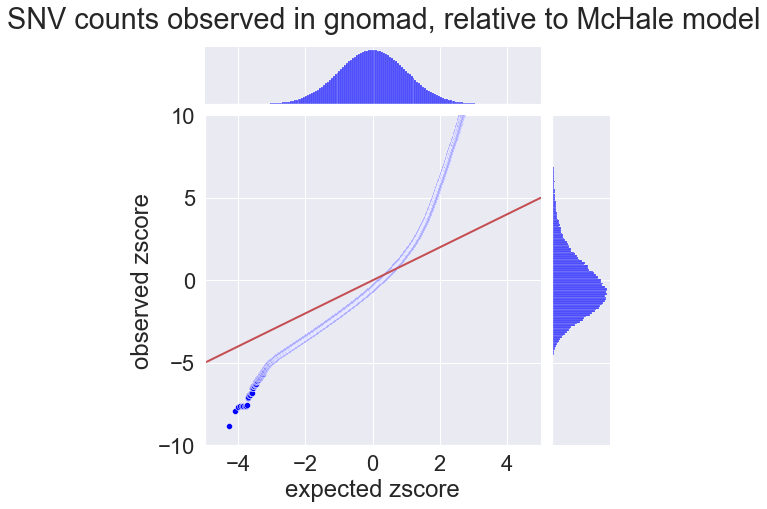

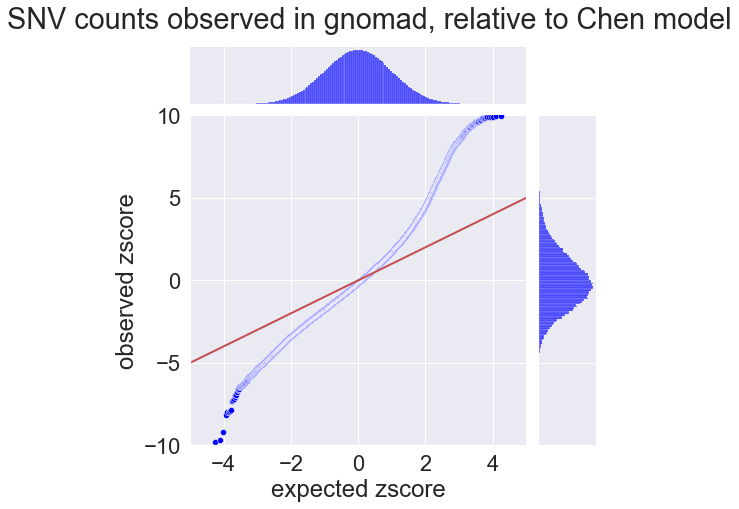

In [6]:
def compute_mchale_zscores(df):
    zscores = df[f'N_bar_{KMER_SIZE}_{TRAIN_SET_LABEL}']
    return zscores, 'SNV counts observed in gnomad, relative to McHale model' 

def compute_chen_zscores(df): 
    zscores = df['negative new chen zscore']
    return zscores, 'SNV counts observed in gnomad, relative to Chen model' 
    
generate_qq_plot_for_zscores(windows_scores_annotations_noncoding.sample(n=SAMPLE_SIZE), compute_mchale_zscores)
generate_qq_plot_for_zscores(windows_scores_annotations_noncoding.sample(n=SAMPLE_SIZE), compute_chen_zscores)

## TODO

1. show perfect correlation between zscores and pvalues (both expected, and observed)
2. plot fraction of pvalues less than x against x (another way to measure inflation/mis-calibration)




